In [37]:
import pandas as pd
import os
import image_similarity as imgsim
import numpy as np
import shutil

In [ ]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "train_dataset/cv_open_dataset/open_img")
# data_dir = os.path.join(os.path.dirname(os.getcwd()), "train_dataset/cv_synt_dataset/synt_img/")



In [4]:
import re
import pathlib

def collect_files(data_dir, extension_regex):
    dir_files = pathlib.Path(data_dir).rglob("*")
    return [str(fname) for fname in dir_files if extension_regex.match(str(fname))]

In [5]:
jpg_extension = re.compile('.*jpg$', flags= re.IGNORECASE)
png_extension = re.compile('.*png$', flags= re.IGNORECASE)


In [6]:
# create images dataframe 
# columns: image_fname, image_id, tag = (syn/real)

def build_image_df(data_dir, extenstion_regex, tag):
    images = collect_files(data_dir, extenstion_regex)

    image_df = pd.DataFrame(images, columns=['image_fname'])
    image_df['image_id'] = image_df['image_fname'].apply(lambda x: x.split('/')[-1].split('.')[0])
    image_df['tag'] = tag
    
    return image_df

In [31]:
image_df = build_image_df(data_dir, jpg_extension, 0)

In [ ]:
# generate embeddings for images

ImgSim = imgsim.Img2Vec('resnet18', weights='DEFAULT')

embeddings = []

for image_fname in image_df['image_fname']:
    embedding = ImgSim.embed_image(image_fname).cpu().detach().numpy()
    embeddings.append(embedding.reshape((-1)))

In [ ]:
# cluster embeddings

from sklearn.cluster import KMeans
import joblib

data = np.array(embeddings)

# save cluster model
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(data)
joblib.dump(kmeans_model, "cluster_model.joblib")

kmeans_labels = kmeans_model.predict(data)


In [ ]:
# dim reduction for embeeddings

import umap

clusterable_embedding = umap.UMAP(    
    min_dist=0.2,    
    random_state=42,
).fit_transform(data)

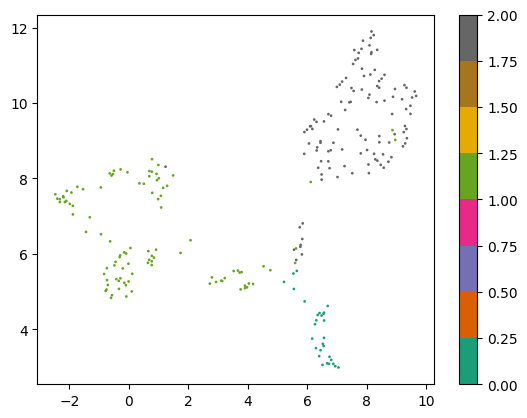

In [47]:
import matplotlib.pyplot as plt

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=kmeans_labels, s=0.9, cmap='Dark2')
plt.colorbar()
plt.show()

In [39]:
image_df['color_cluster'] = kmeans_labels

In [22]:
image_df[['image_id', 'color_cluster']].groupby(by=['color_cluster']).count()

,image_id
color_cluster,
0,29
1,103
2,114


In [23]:
from PIL import Image
import random 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_random_instanses(df, cluster_id, grid_size=2, figsize=(8., 8.)):
    image_cluster = df[df['color_cluster'] == cluster_id].reset_index(drop=True)
    cluster_size = len(image_cluster)

    images = []
    for i in range(grid_size * grid_size):
        index = random.randint(0, cluster_size)
        fname = image_cluster['image_fname'].iloc[index]        
        image = Image.open(fname)
        
        images.append(np.array(image))
    
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(grid_size, grid_size), 
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()

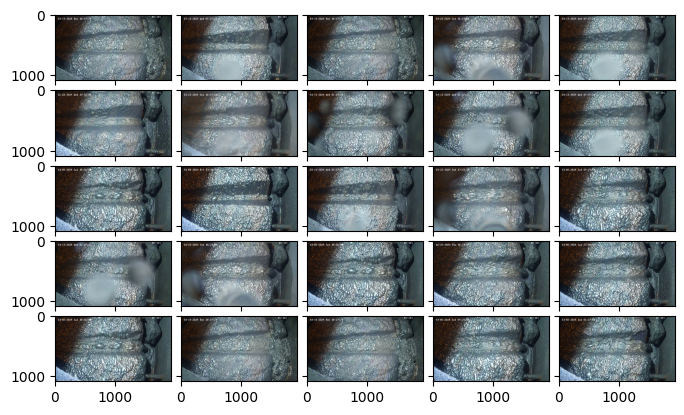

In [28]:
plot_random_instanses(image_df, 0, grid_size=5)

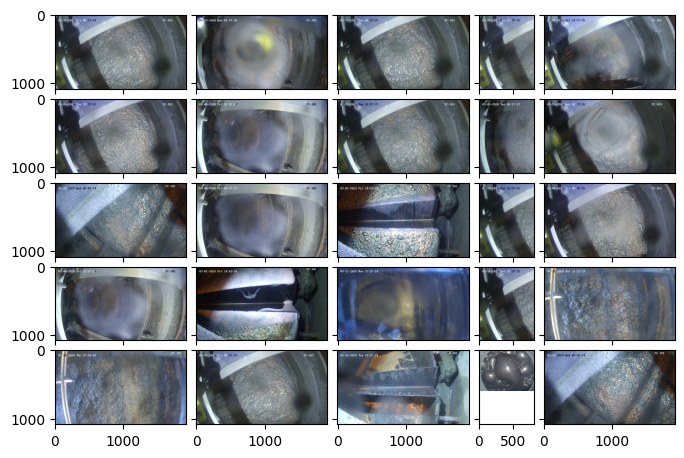

In [29]:
plot_random_instanses(image_df, 1, grid_size=5)

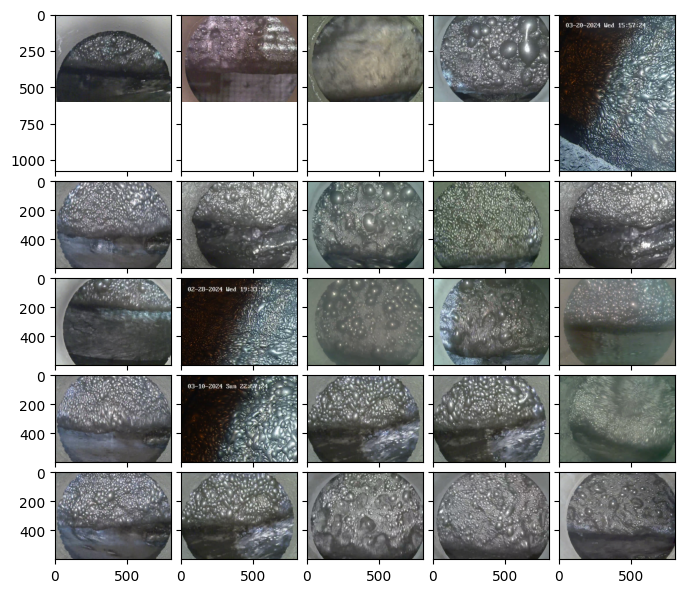

In [30]:
plot_random_instanses(image_df, 2, grid_size=5)

Split original dataset into clusters

In [35]:
data_dir = "clustered_images"

In [43]:
# prepare directories for cluster ids

for i in np.unique(kmeans_labels):
    os.makedirs(os.path.join(data_dir, str(i)), exist_ok=True)

In [44]:
# split images acording to their cluster ids

for i in range(len(image_df)):
    row = image_df.iloc[i]
    cluster_id = row['color_cluster']
    src = row['image_fname']
    image_fname = src.split('/')[-1]
    dst = os.path.join(data_dir, str(cluster_id), image_fname)
    shutil.copyfile(src, dst)
